In [1]:
import os
import errno
import pandas as pd
import numpy as np
import deepcell
import math


from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from deepcell.utils.io_utils import *
from deepcell.utils.plot_utils import get_js_video
from IPython.display import HTML
from tensorflow.python.keras import backend as K

In [161]:
from skimage.feature import peak_local_max, corner_peaks
from skimage.measure import label
from skimage.morphology import watershed, remove_small_objects
from skimage.segmentation import relabel_sequential

from deepcell_toolbox.utils import erode_edges

def deep_watershed_3D(outputs,
                   min_distance=10,
                   detection_threshold=0.1,
                   distance_threshold=0.01,
                   exclude_border=False,
                   small_objects_threshold=0):
    """Postprocessing function for deep watershed models. Thresholds the inner
    distance prediction to find cell centroids, which are used to seed a marker
    based watershed of the outer distance prediction.

    Args:
        outputs (list): DeepWatershed model output. A list of
            [inner_distance, outer_distance, fgbg].

            - inner_distance: Prediction for the inner distance transform.
            - outer_distance: Prediction for the outer distance transform.
            - fgbg: Prediction for the foregound/background transform.

        min_distance (int): Minimum allowable distance between two cell centroids.
        detection_threshold (float): Threshold for the inner distance.
        distance_threshold (float): Threshold for the outer distance.
        exclude_border (bool): Whether to include centroid detections
            at the border.
        small_objects_threshold (int): Removes objects smaller than this size.

    Returns:
        numpy.array: Uniquely labeled mask.
    """
    inner_distance_batch = outputs[0][:, ..., 0]
    outer_distance_batch = outputs[1][:, ..., 0]

    label_images = []
    for batch in range(inner_distance_batch.shape[0]):
        inner_distance = inner_distance_batch[batch]
        outer_distance = outer_distance_batch[batch]

        coords = peak_local_max(inner_distance,
                                min_distance=min_distance,
                                threshold_abs=detection_threshold,
                                exclude_border=exclude_border)
        
        # Find peaks and merge equal regions        
        markers = np.zeros(inner_distance.shape)
        markers[coords[:, 0], coords[:, 1], coords[:,2]] = 1
        markers = label(markers)        
        
        label_image = watershed(-outer_distance,
                                markers,
                                mask=outer_distance > distance_threshold)
        label_image = erode_edges(label_image, 1)

        # Remove small objects
        label_image = remove_small_objects(label_image, min_size=small_objects_threshold)

        # Relabel the label image
        label_image, _, _ = relabel_sequential(label_image)

        label_images.append(label_image)
    
    label_images = np.stack(label_images, axis=0)

    mask=outer_distance > distance_threshold
    return label_images, mask


In [228]:
import glob

def _load_3D_ims_from_npz(path_to_data, img_shape, n_channels=1, n_features=1):
    
    X_list = []
    y_list = []
    
    shape_x = (img_shape[0], img_shape[1], img_shape[2], n_channels)
    shape_y = (img_shape[0], img_shape[1], img_shape[2], n_features)
    
    for path_to_npz in glob.glob(os.path.join(path_to_data, '*.npz')):

        with np.load(path_to_npz) as load_data:
            X = np.expand_dims(load_data['raw'][..., 0], -1)
            y = np.expand_dims(load_data['annotated'][..., 0], -1)
            
            #print(X.shape)
            
        X_padded = np.zeros(shape_x, dtype=X.dtype)
        y_padded = np.zeros(shape_y, dtype=y.dtype)
        
        f_dim = X.shape[0] ##
        x_dim = X.shape[1] ##
        y_dim = X.shape[2] ##
        
        X_padded[:f_dim, :x_dim, :y_dim, :] = X
        y_padded[:f_dim, :x_dim, :y_dim, :] = y
        
        X_list.append(X_padded)
        y_list.append(y_padded)
    
    X = np.stack(X_list, axis=0)
    y = np.stack(y_list, axis=0)
    
    return X, y

In [229]:
path_to_data = '/deepcell_data/users/geneva/raj_organoid_npzs/corrected/'

X, y = _load_3D_ims_from_npz(path_to_data=path_to_data, img_shape=(50, 512, 512))

In [230]:
def tile_image_3D(image, model_input_shape=(10, 256, 256), stride_ratio=0.5):
    """
    Tile large image into many overlapping tiles of size "model_input_shape".

    Args:
        image (numpy.array): The 3D image to tile, must be rank 5.
        model_input_shape (tuple): The input size of the model.
        stride_ratio (float): The stride expressed as a fraction of the tile sizet

    Returns:
        tuple(numpy.array, dict): An tuple consisting of an array of tiled
            images and a dictionary of tiling details (for use in un-tiling).

    Raises:
        ValueError: image is not rank 5.
    """
    if image.ndim != 5:
        raise ValueError('Expected image of 5, got {}'.format(
            image.ndim))

    image_size_z, image_size_x, image_size_y = image.shape[1:4]
    tile_size_z = model_input_shape[0]
    tile_size_x = model_input_shape[1]
    tile_size_y = model_input_shape[2]

    ceil = lambda x: int(np.ceil(x))
    round_to_even = lambda x: int(np.ceil(x / 2.0) * 2)

    stride_z = min(round_to_even(stride_ratio * tile_size_z), tile_size_z)
    stride_x = min(round_to_even(stride_ratio * tile_size_x), tile_size_x)
    stride_y = min(round_to_even(stride_ratio * tile_size_y), tile_size_y)

    rep_number_z = max(ceil((image_size_z - tile_size_z) / stride_z + 1), 1)
    rep_number_x = max(ceil((image_size_x - tile_size_x) / stride_x + 1), 1)
    rep_number_y = max(ceil((image_size_y - tile_size_y) / stride_y + 1), 1)
    new_batch_size = image.shape[0] * rep_number_z * rep_number_x * rep_number_y

    # catches error caused by interpolation along z axis with rep number = 1
    # TODO - create a better solution or figure out why it doesn't occur in x and y planes
    if rep_number_z == 1:
        stride_z = tile_size_z

    tiles_shape = (new_batch_size, tile_size_z, tile_size_x, tile_size_y, image.shape[4])
    tiles = np.zeros(tiles_shape, dtype=image.dtype)

    # Calculate overlap of last tile along each axis
    overlap_z = (tile_size_z + stride_z * (rep_number_z - 1)) - image_size_z
    overlap_x = (tile_size_x + stride_x * (rep_number_x - 1)) - image_size_x
    overlap_y = (tile_size_y + stride_y * (rep_number_y - 1)) - image_size_y

    # Calculate padding needed to account for overlap and pad image accordingly
    pad_z = (int(np.ceil(overlap_z / 2)), int(np.floor(overlap_z / 2)))
    pad_x = (int(np.ceil(overlap_x / 2)), int(np.floor(overlap_x / 2)))
    pad_y = (int(np.ceil(overlap_y / 2)), int(np.floor(overlap_y / 2)))
    pad_null = (0, 0)
    padding = (pad_null, pad_z, pad_x, pad_y, pad_null)
    image = np.pad(image, padding, 'constant', constant_values=0)

    counter = 0
    batches = []
    z_starts = []
    z_ends = []
    x_starts = []
    x_ends = []
    y_starts = []
    y_ends = []
    overlaps_z = []
    overlaps_x = []
    overlaps_y = []
    z_axis = 1
    x_axis = 2
    y_axis = 3

    for b in range(image.shape[0]):
        for i in range(rep_number_x):
            for j in range(rep_number_y):
                for k in range(rep_number_z):
                    # Compute the start and end for each tile
                    if i != rep_number_x - 1:  # not the last one
                        x_start, x_end = i * stride_x, i * stride_x + tile_size_x
                    else:
                        x_start, x_end = image.shape[x_axis] - tile_size_x, image.shape[x_axis]

                    if j != rep_number_y - 1:  # not the last one
                        y_start, y_end = j * stride_y, j * stride_y + tile_size_y
                    else:
                        y_start, y_end = image.shape[y_axis] - tile_size_y, image.shape[y_axis]

                    if k != rep_number_z - 1:  # not the last one
                        z_start, z_end = k * stride_z, k * stride_z + tile_size_z
                    else:
                        z_start, z_end = image.shape[z_axis] - tile_size_z, image.shape[z_axis]

                    # Compute the overlaps for each tile
                    if i == 0:
                        overlap_x = (0, tile_size_x - stride_x)
                    elif i == rep_number_x - 2:
                        overlap_x = (tile_size_x - stride_x,
                                     tile_size_x - image.shape[x_axis] + x_end)
                    elif i == rep_number_x - 1:
                        overlap_x = ((i - 1) * stride_x + tile_size_x - x_start, 0)
                    else:
                        overlap_x = (tile_size_x - stride_x, tile_size_x - stride_x)

                    if j == 0:
                        overlap_y = (0, tile_size_y - stride_y)
                    elif j == rep_number_y - 2:
                        overlap_y = (tile_size_y - stride_y,
                                     tile_size_y - image.shape[y_axis] + y_end)
                    elif j == rep_number_y - 1:
                        overlap_y = ((j - 1) * stride_y + tile_size_y - y_start, 0)
                    else:
                        overlap_y = (tile_size_y - stride_y, tile_size_y - stride_y)

                    if k == 0:
                        overlap_z = (0, tile_size_z - stride_z)
                    elif k == rep_number_z - 2:
                        overlap_z = (tile_size_z - stride_z,
                                     tile_size_z - image.shape[z_axis] + z_end)
                    elif k == rep_number_z - 1:
                        overlap_z = ((k - 1) * stride_z + tile_size_z - z_start, 0)
                    else:
                        overlap_z = (tile_size_z - stride_z, tile_size_z - stride_z)

                    tiles[counter] = image[b, z_start:z_end, x_start:x_end, y_start:y_end, :]
                    batches.append(b)
                    x_starts.append(x_start)
                    x_ends.append(x_end)
                    y_starts.append(y_start)
                    y_ends.append(y_end)
                    z_starts.append(z_start)
                    z_ends.append(z_end)
                    overlaps_x.append(overlap_x)
                    overlaps_y.append(overlap_y)
                    overlaps_z.append(overlap_z)
                    counter += 1

    tiles_info = {}
    tiles_info['batches'] = batches
    tiles_info['x_starts'] = x_starts
    tiles_info['x_ends'] = x_ends
    tiles_info['y_starts'] = y_starts
    tiles_info['y_ends'] = y_ends
    tiles_info['z_starts'] = z_starts
    tiles_info['z_ends'] = z_ends
    tiles_info['overlaps_x'] = overlaps_x
    tiles_info['overlaps_y'] = overlaps_y
    tiles_info['overlaps_z'] = overlaps_z
    tiles_info['stride_x'] = stride_x
    tiles_info['stride_y'] = stride_y
    tiles_info['stride_z'] = stride_z
    tiles_info['tile_size_x'] = tile_size_x
    tiles_info['tile_size_y'] = tile_size_y
    tiles_info['tile_size_z'] = tile_size_z
    tiles_info['stride_ratio'] = stride_ratio
    tiles_info['image_shape'] = image.shape
    tiles_info['dtype'] = image.dtype
    tiles_info['pad_x'] = pad_x
    tiles_info['pad_y'] = pad_y
    tiles_info['pad_z'] = pad_z

    return tiles, tiles_info

In [231]:
from skimage.measure import regionprops
from scipy import stats

import statistics

def get_3D_cell_dimensions(vid, channel=0):
    
    z_list = []
    x_list = []
    y_list = []
    
    for batch in range(vid.shape[0]):
        
        regions = regionprops(vid[batch, ..., channel])
        
        for region in regions:
            bbox = region.bbox
            z_list.append(bbox[3] - bbox[0])
            x_list.append(bbox[4] - bbox[1])
            y_list.append(bbox[5] - bbox[2])

        zstats = stats.describe(np.asarray(z_list))
        xstats = stats.describe(np.asarray(x_list))
        ystats = stats.describe(np.asarray(y_list))
    
    return zstats, xstats, ystats
        
    
    
zdims, xdims, ydims = get_3D_cell_dimensions(y)

In [232]:
zdims

DescribeResult(nobs=2725, minmax=(1, 26), mean=5.868990825688074, variance=10.747514583249135, skewness=1.569484780035604, kurtosis=4.3547644322913355)

In [233]:
xdims

DescribeResult(nobs=2725, minmax=(5, 190), mean=24.517064220183485, variance=50.35259049697557, skewness=6.601499024926425, kurtosis=130.12196061710625)

In [234]:
ydims

DescribeResult(nobs=2725, minmax=(8, 198), mean=25.020550458715597, variance=71.82923978498968, skewness=7.433708818768968, kurtosis=115.3577023428403)

In [235]:
# Tile X and y into overlapping tiles 

im_shape = (13, 64, 64)
stride_ratio = 0.5

X_tiles, tiles_info_X = tile_image_3D(X, model_input_shape=im_shape, stride_ratio=stride_ratio)
y_tiles, tiles_info_y = tile_image_3D(y, model_input_shape=im_shape, stride_ratio=stride_ratio)

print('Shape of X_tiles is {} and shape of y_tiles is {}'.format(X_tiles.shape, y_tiles.shape))

Shape of X_tiles is (24300, 13, 64, 64, 1) and shape of y_tiles is (24300, 13, 64, 64, 1)


In [236]:
# Remove tiles that do not contain cells

X_list = list(X_tiles)
y_list = list(y_tiles)


X_new = []
y_new = []

for tile in range(0, len(X_list)):
    if y_list[tile].max() > 0:
        X_new.append(X_list[tile])
        y_new.append(y_list[tile])

X_tiles = np.asarray(X_new)
y_tiles = np.asarray(y_new)

print('Shape of X_tiles is {} and shape of y_tiles is {}'.format(X_tiles.shape, y_tiles.shape))

Shape of X_tiles is (5606, 13, 64, 64, 1) and shape of y_tiles is (5606, 13, 64, 64, 1)


In [237]:
# Split data into train and test

seed=7
X_train, X_test, y_train, y_test = train_test_split(X_tiles, y_tiles, test_size=0.1, random_state=seed)


## Set up filepath constants


In [238]:
# change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = path_to_data

# DATA_FILE should be an npz file, preferably from `make_training_data`
filename = 'Raj_3D_sliced.npz'
DATA_FILE = os.path.join(DATA_DIR, filename)

# Save as .npz
#np.savez_compressed(DATA_FILE, X=X, y=y)

# confirm the data file is available
#assert os.path.isfile(DATA_FILE)

In [239]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/deepcell_data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

print(MODEL_DIR)

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

/deepcell_data/models


## Create the PanopticNet Model

Here we instantiate a `PanopticNet` model from `deepcell.model_zoo` using 3 semantic heads:
inner distance (1 class),
outer distance (1 class),
foreground/background distance (2 classes)

In [240]:
frames_per_batch = 12
temporal_mode = 'conv'      # Options are: None, 'conv', 'lstm', 'gru'

In [241]:
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[2:],
    frames_per_batch=frames_per_batch, 
    norm_method='std',
    num_semantic_heads=3,
    temporal_mode=temporal_mode,
    num_semantic_classes=[1, 1, 2], # inner distance, outer distance, fgbg
    location=True,  # should always be true
    include_top=True)

## Prepare for training

### Set up training parameters.

There are a number of tunable hyper parameters necessary for training deep learning models:

**model_name**: Incorporated into any files generated during the training process.

**backbone**: The majority of DeepCell models support a variety backbone choices specified in the "backbone" parameter. Backbones are provided through [keras_applications](https://github.com/keras-team/keras-applications) and can be instantiated with weights that are pretrained on ImageNet.

**n_epoch**: The number of complete passes through the training dataset.

**lr**: The learning rate determines the speed at which the model learns. Specifically it controls the relative size of the updates to model values after each batch.

**optimizer**: The TensorFlow module [tf.keras.optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) offers optimizers with a variety of algorithm implementations. DeepCell typically uses the Adam or the SGD optimizers.

**lr_sched**: A learning rate scheduler allows the learning rate to adapt over the course of model training. Typically a larger learning rate is preferred during the start of the training process, while a small learning rate allows for fine-tuning during the end of training.

**batch_size**: The batch size determines the number of samples that are processed before the model is updated. The value must be greater than one and less than or equal to the number of samples in the training dataset.


In [242]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = 'raj_3D_watershed_test'
model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

n_epoch = 5  # Number of training epochs
test_size = .10  # % of data saved as test
norm_method = 'whole_image'  # data normalization

optimizer = Adam(lr=1e-5, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-5, decay=0.99)

batch_size = 8

min_objects = 1  # throw out images with fewer than this many objects

### Create the DataGenerators

The `SemanticDataGenerator` can output any number of transformations for each image. These transformations are passed to `generator.flow()` as a list of transform names.

Here we use `"inner-distance"`, `"outer-distance"` and `"fgbg"` to correspond to the inner distance, outer distance, and foreground background semantic heads, respectively. Keyword arguments may also be passed to each transform as a `dict` of transform names to `kwargs`.

In [243]:
from deepcell import image_generators
from deepcell.utils import train_utils

# if by_frame = True, transform inner and outer distance frame by frame
# if by_frame = False, transform inner and outer distance as 3D
by_frame_inner = False
by_frame_outer = True

fill_mode = 'nearest'

transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0, 'by_frame' : by_frame_outer},
                     'inner-distance': {'by_frame' : by_frame_inner}}

# use augmentation for training but not validation
datagen = image_generators.SemanticMovieGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.75, 1.25),
    fill_mode=fill_mode,
    cval=0,
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticMovieGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    fill_mode=fill_mode,
    cval=0,
    horizontal_flip=0,
    vertical_flip=0)

In [244]:
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    frames_per_batch=frames_per_batch,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    frames_per_batch=frames_per_batch,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

In [245]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]

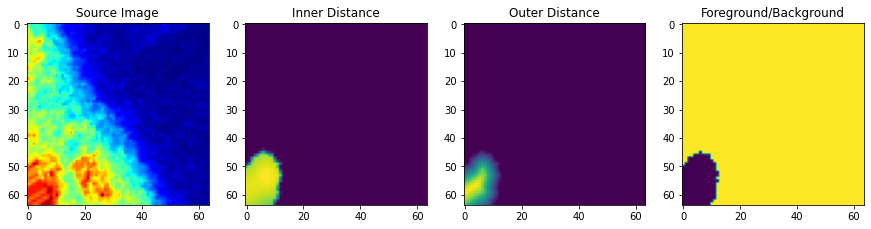

In [246]:
fig, axes = plt.subplots(1, 4, figsize=(15, 15))

slice=0

axes[0].imshow(img[slice, ..., 0], cmap='jet')
axes[0].set_title('Source Image')

axes[1].imshow(inner_distance[0, slice, ..., 0])
axes[1].set_title('Inner Distance')

axes[2].imshow(outer_distance[0, slice, ..., 0])
axes[2].set_title('Outer Distance')

axes[3].imshow(fgbg[0, slice, ..., 0])
axes[3].set_title('Foreground/Background')

plt.show()

In [216]:
HTML(get_js_video(inputs, batch=0, channel=0, interval=1000, cmap='plasma'))

In [217]:
HTML(get_js_video(inner_distance, batch=0, channel=0, interval=1000))

### Create a loss function for each semantic head

Each semantic head is trained with it's own loss function. Mean Square Error is used for regression-based heads, whereas `weighted_categorical_crossentropy` is used for classification heads.

The losses are saved as a dictionary and passed to `model.compile`.

In [247]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)
        
model.compile(loss=loss, optimizer=optimizer)

In [248]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus




num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/5
629/630 [============================>.] - ETA: 0s - loss: 0.1694 - semantic_0_loss: 0.0320 - semantic_1_loss: 0.1332 - semantic_2_loss: 0.0042
Epoch 00001: val_loss improved from inf to 0.02979, saving model to /deepcell_data/models/raj_3D_watershed_test.h5
630/630 [==============================] - 517s 820ms/step - loss: 0.1692 - semantic_0_loss: 0.0320 - semantic_1_loss: 0.1330 - semantic_2_loss: 0.0042 - val_loss: 0.0298 - val_semantic_0_loss: 0.0191 - val_semantic_1_loss: 0.0083 - val_semantic_2_loss: 0.0024
Epoch 2/5
629/630 [============================>.] - ETA: 0s - loss: 0.0264 - semantic_0_loss: 0.0162 - semantic_1_loss: 0.0082 - semantic_2_loss: 0.0020
Epoch 00002: val_loss improved from 0.02979 to 0.02733, saving model to /deepcell_data/models/raj_3D_watershed_test.h5
630/630 [==============================] - 341s 541ms/step - loss: 0.0264 - semantic_0_loss: 0.0162 - semantic_1_loss: 0.0082 - semantic_2_loss: 0.0020 - val_loss: 0.0273 - val_

## Predict on test data

Use the trained model to predict on new data. First, create a new prediction model without the foreground background semantic head. While this head is very useful during training, the output is unused during prediction. By using `model.load_weights(path, by_name=True)`, the semantic head can be removed.

In [249]:
from deepcell.model_zoo.panopticnet import PanopticNet       

pred_frames_per_batch = frames_per_batch
temporal_mode = temporal_mode

prediction_model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[2:],
    frames_per_batch=pred_frames_per_batch,
    norm_method='std',
    num_semantic_heads=2,
    temporal_mode=temporal_mode,
    num_semantic_classes=[1, 1], # inner distance, outer distance
    location=True,  # should always be true
    include_top=True)

prediction_model.load_weights(model_path, by_name=True)

In [250]:
# make predictions on testing data
from timeit import default_timer

begin_frame = 0
end_frame = 5

start = default_timer()
test_images = prediction_model.predict(X_test[begin_frame:end_frame, 0:frames_per_batch, ...])
watershed_time = default_timer() - start

print('Watershed segmentation of shape', test_images[0].shape, 'in', watershed_time, 'seconds.')

Watershed segmentation of shape (5, 12, 64, 64, 1) in 14.762196206022054 seconds.


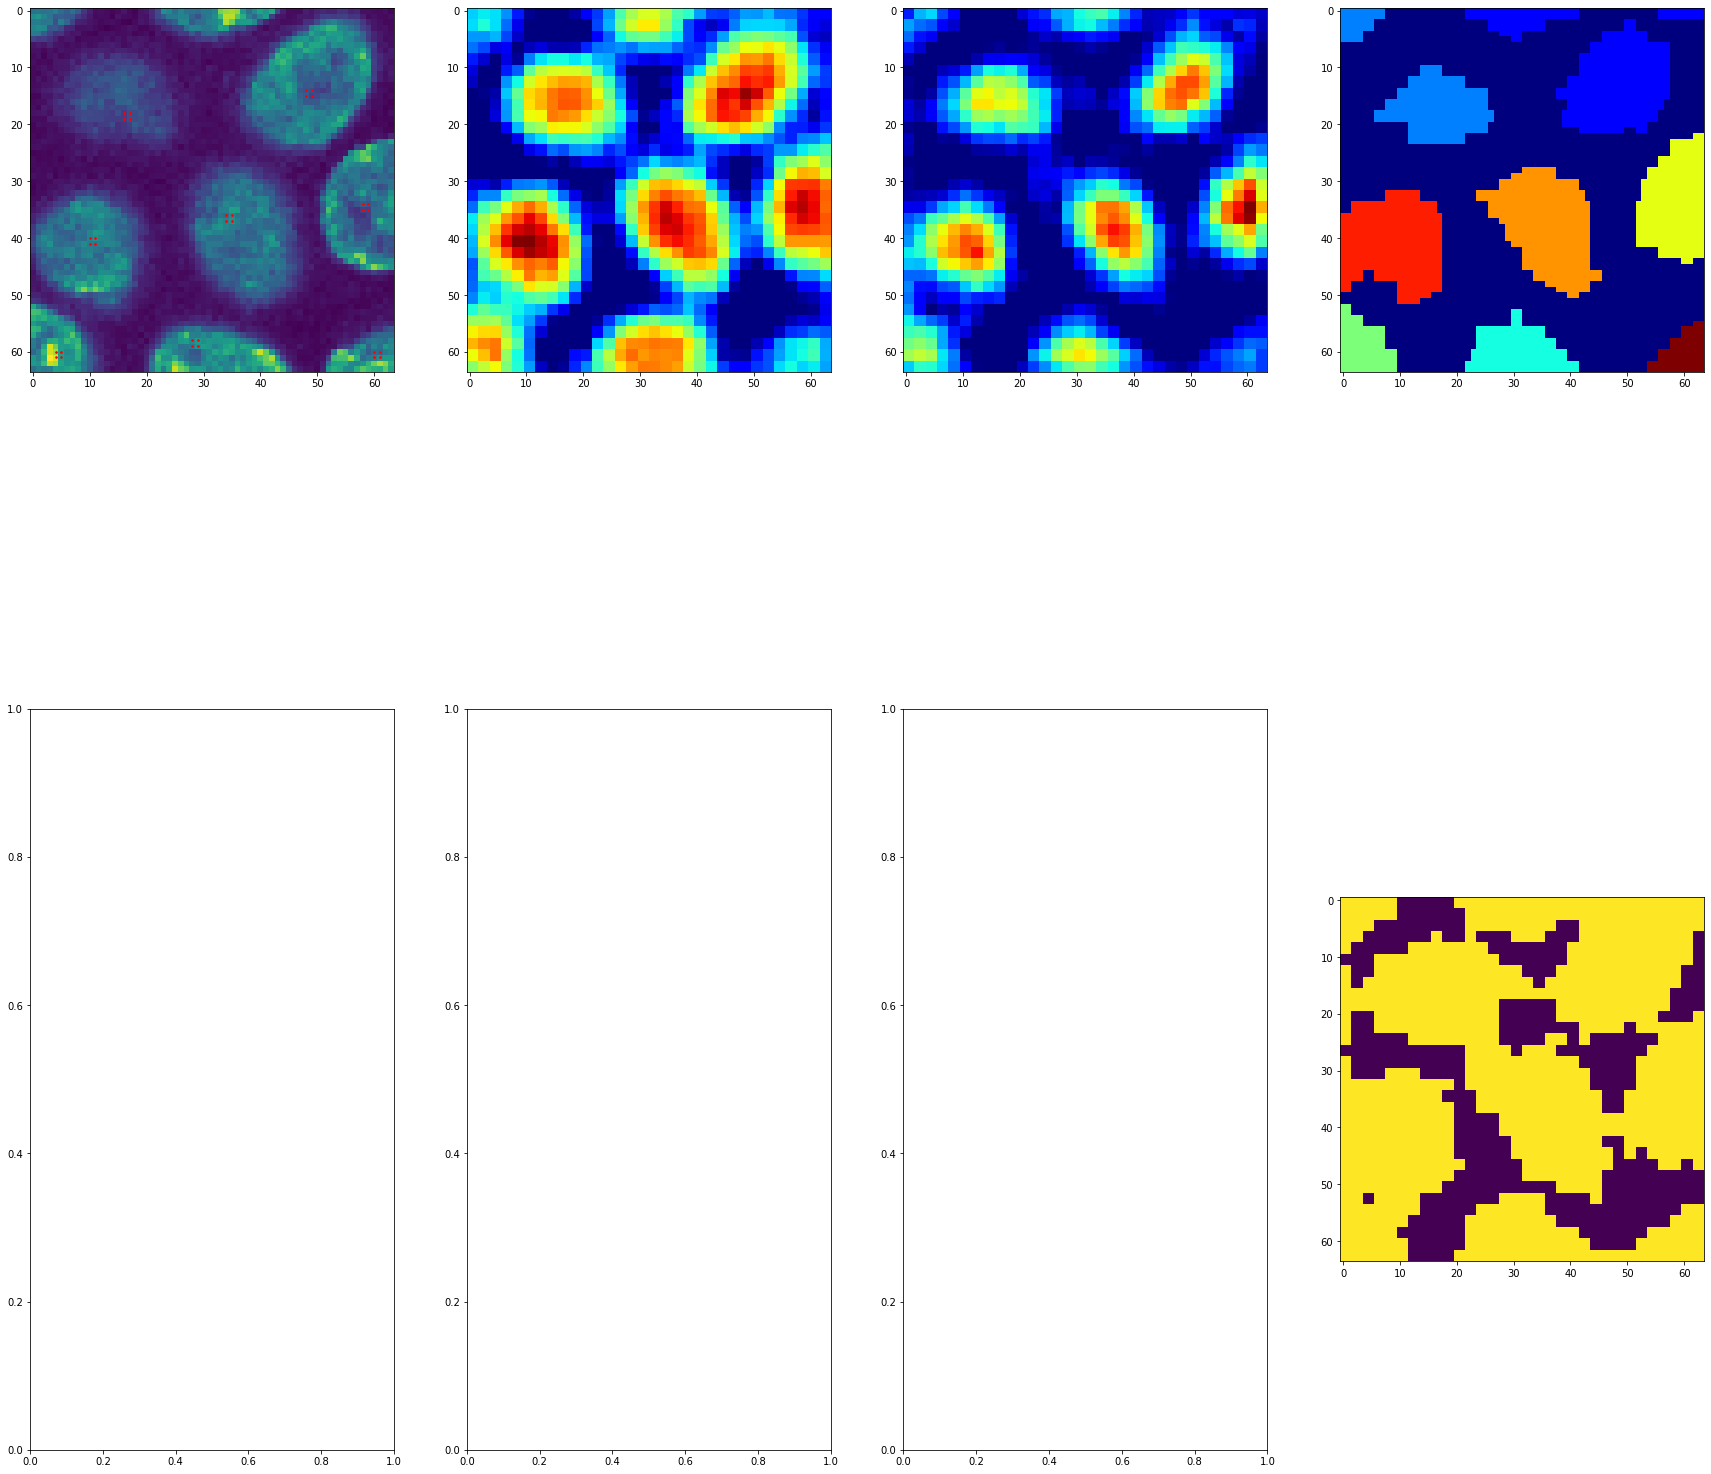

In [253]:
import time

from matplotlib import pyplot as plt
import numpy as np

from skimage.feature import peak_local_max

#from deepcell_toolbox.deep_watershed import deep_watershed_3D

masks, outer = deep_watershed_3D(
    test_images,
    min_distance=10,
    detection_threshold=0.01,
    distance_threshold=0.01,
    exclude_border=False,
    small_objects_threshold=50)

# calculated in the postprocessing above, but useful for visualizing
inner_distance = test_images[0]
outer_distance = test_images[1]

fig, axes = plt.subplots(2, 4, figsize=(30, 30))

index = 4
slice = 6

coords = peak_local_max(
    inner_distance[index],
    min_distance=10,
    threshold_abs=0.1,
    exclude_border=False)

# raw image with centroid
axes[0, 0].imshow(X_test[index+begin_frame, slice, ..., 0])
axes[0, 0].scatter(coords[..., 2], coords[..., 1],
                color='r', marker='.', s=10)

axes[0, 1].imshow(inner_distance[index, slice, ..., 0], cmap='jet')
axes[0, 2].imshow(outer_distance[index, slice, ..., 0], cmap='jet')
axes[0, 3].imshow(masks[index, slice, ...], cmap='jet')

axes[1, 3].imshow(outer[slice, ...])

plt.show()

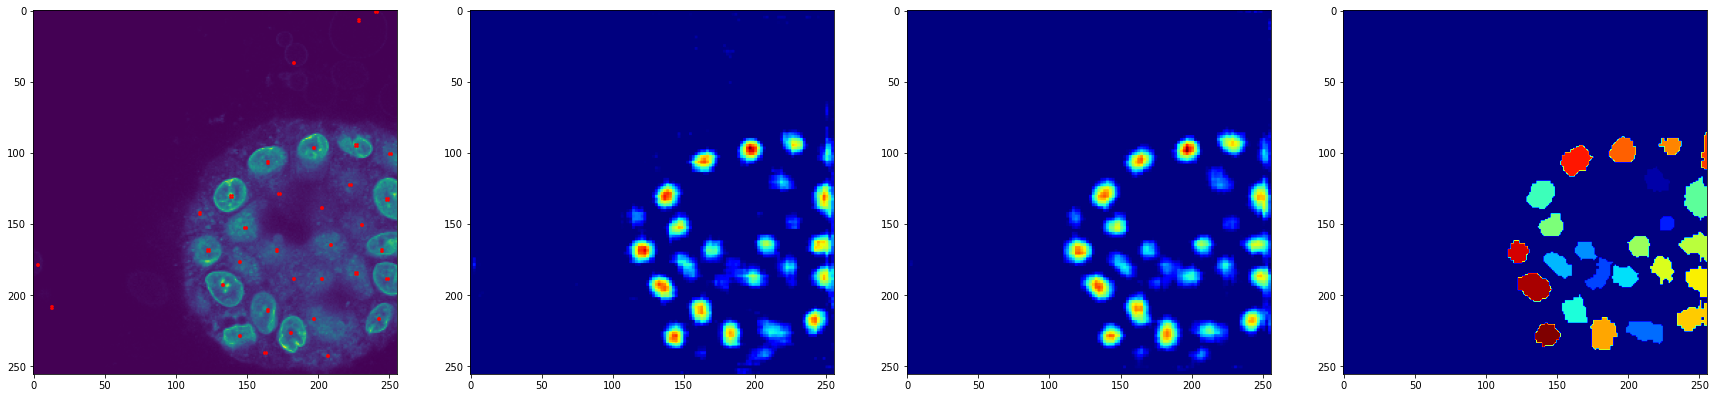

In [252]:
# Play movie of the predicted masks
vid_msk = np.expand_dims(masks, axis=1)
vid_msk = np.expand_dims(vid_msk, axis=-1)

HTML(get_js_video(vid_msk[index], batch=0, channel=0, interval=800))

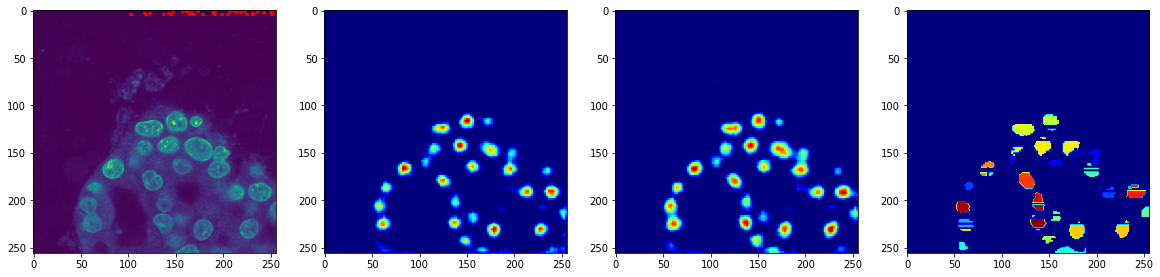

In [34]:
import time

from matplotlib import pyplot as plt
import numpy as np

from skimage.feature import peak_local_max

from deepcell_toolbox.deep_watershed import deep_watershed

masks = deep_watershed(
    test_images,
    min_distance=10,
    detection_threshold=0.1,
    distance_threshold=0.01,
    exclude_border=False,
    small_objects_threshold=0)

# calculated in the postprocessing above, but useful for visualizing
inner_distance = test_images[0]
outer_distance = test_images[1]

fig, axes = plt.subplots(1, 4, figsize=(20, 20))

index = 8
slice = 2

coords = peak_local_max(
    inner_distance[index],
    min_distance=10,
    threshold_abs=0.1,
    exclude_border=False)

# raw image with centroid
axes[0].imshow(X_test[index+begin_frame, slice, ..., 0])
axes[0].scatter(coords[..., 1], coords[..., 0],
                color='r', marker='.', s=10)

axes[1].imshow(inner_distance[index, slice, ..., 0], cmap='jet')
axes[2].imshow(outer_distance[index, slice, ..., 0], cmap='jet')
axes[3].imshow(masks[index, slice, ...], cmap='jet')

plt.show()

In [ ]:
# channels = ['dapi', 'gfp', 'nuclei']
# data = _get_3D_images_from_directory(path_to_data, channels)


# convert data to np.array

# X = data[..., 0:1]
# y = data[..., 2]


# X_train, y_train, X_test, y_test = train_test_split(X, y, test_size = 0.2, random_state=seed)

# reshape_movie to size 256
# HTML(get_js_video(ims[7], batch=0, channel=2))

In [ ]:
'''
# TODO - make this work with overlaps aside from slices-1
# actually jk dont think we need this at all.
# might want it to cut z stacks in half to increase # batches though - just get rid of overlap

def _overlapping_slices_3D(input_array, output_slices=5, overlap=4):
    
    input_num_stacks = input_array.shape[0]
    input_frames = input_array.shape[1]    # should be 50
    input_x = input_array.shape[2]
    input_y = input_array.shape[3]
    input_chan = input_array.shape[4]
    
    increment = output_slices - overlap
    final_z_start = input_frames + 1 - output_slices
    
    num_per_stack = math.trunc(final_z_start / increment)    # number of stacks obtained from one input z_stack
    output_height = num_per_stack * input_num_stacks
    print('output height = ', output_height)
    
    
    stack_height = 0   
    
    sliced = np.zeros((output_height, output_slices, input_x, input_y, input_chan), dtype='float32')

    print('shape of sliced = ', sliced.shape)
    
    for z_start in range(0, final_z_start, increment):
        
        z_end = z_start + output_slices
        z_stack = input_array[:, z_start:z_end, ...]
        
        # print('z_stack shape = ', z_stack.shape)
        
        sliced[stack_height:stack_height+input_num_stacks, ...] = z_stack
        
        #sliced = np.concatenate((sliced, z_stack), axis=0)
        
        stack_height += input_num_stacks   # increment by num_stacks (e.g. 18)
    
    
    return sliced

#Slice data into overlapping stacks 5 frames high
sliced_data = _overlapping_slices_3D(raw_img_array, overlap=4)#
X = sliced_data[..., 0:2]
y = sliced_data[..., 2:3]

# No need to slice data
#X = raw_img_array[..., 0:2]
#y = raw_img_array[..., 2:3]

print('Shape of raw_img_array is: ', raw_img_array.shape)
print('Shape of X is: ', X.shape)
print('Shape of y is: ', y.shape)
''''''